# LikeWise

### A Comparison of Book Recommender Systems

### By _Owen Burton_ and _Tobias Reaper_

---
---

## Outline

* [Introduction]()
* [_Imports and Configuration_]()
* [Data]()
  * [Loading and Looking]()
  * [Wrangling and Exploration]()

---
---

## Introduction

### Stop! Collaborate and Filter

[Collaborative Filtering](https://d2l.ai/chapter_recommender-systems/recsys-intro.html#collaborative-filtering) (CF)

> In general, CF only uses the user-item interaction data to make predictions and recommendations.

---
---

## Imports and Configuration

In [1]:
# === General imports === #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# === fastai imports === #
from fastai.collab import *

In [3]:
# === Configuration === #
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---
---

## Data

Intro to and explanation of dataset — why this dataset?

Here is the dataset used for the LikeWise recommender systems: [UCSD Book Graph - GoodReads Datasets](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home).

For this particular model, I'll be using the "Shelves" dataset, which has interactions between users and books (ratings).

The relevant columns are `user_id`, `book_id`, and `rating`. They are pretty self-explanatory, but just to be explicit, each record indicates a user rating a book that they've (presumably) read and have an opinion on.

Speaking of explicit, the fact that the user _explicitly_ rates the books makes this dataset one of explicit preferences

---

### Load and Look

Load the dataset and look at basic descriptive statistics.

#### Download

To develop and validate the initial models, we'll be using a genre-wise subset of the full interactions dataset for the Mystery, Thriller & Crime genre. This subset contains ~24.8m interactions (1.33 GB), as opposed to the ~229m (4.1 GB?) of the full dataset.

The datasets can be downloaded from the creator's Google Drive using the `gdown` package.

In [4]:
# === Download goodreads_interactions_mystery_thriller_crime.json.gz === #
import gdown

file_id = "1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D"
url = "https://drive.google.com/uc?id=" + file_id
gdown.download(url, output=None, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D
To: /content/goodreads_interactions_mystery_thriller_crime.json.gz
1.33GB [00:16, 83.2MB/s]


'goodreads_interactions_mystery_thriller_crime.json.gz'

In [ ]:
# === Download book_id_map.csv to get titles === #
file_id = "1xuujDT-vOMMkk2Kog0CTT9ADmnD8pa9D"
url = "https://drive.google.com/uc?id=" + file_id
gdown.download(url, output=None, quiet=False)

#### Load sample of interactions

In [69]:
# === First, load from gzipped json === #
import gzip
import json
from typing import List

def load_data(file_name: str, num_items: int) -> List[dict]:
    """Output a list of user-book interactions"""
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            if (num_items is not None) and (count == num_items):
                break
    return data

# === Load sample of 100,000 records === #
interactions = load_data(
    "/content/goodreads_interactions_mystery_thriller_crime.json.gz",
    num_items=100000
)

assert len(interactions) == 100000

In [70]:
# === Take a look at one of the records === #
interactions[-1]

{'book_id': '383028',
 'date_added': 'Fri Oct 03 08:02:16 -0700 2014',
 'date_updated': 'Fri Oct 03 08:02:21 -0700 2014',
 'is_read': False,
 'rating': 0,
 'read_at': '',
 'review_id': '146a9921627d10f82bd6ca12df6efbb2',
 'review_text_incomplete': '',
 'started_at': '',
 'user_id': '80881f5266512e9b860753b2d406d5dd'}

In [71]:
# === Insert into dataframe === #
inters = pd.DataFrame(interactions)
print(inters.shape)
inters.head()

(100000, 10)


,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
0,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,True,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017
1,8842281e1d1347389f2ab93d60773d4d,2279538,556e9e3f00fb5b7e4eaa116764b771b0,False,0,,Wed Mar 29 00:27:14 -0700 2017,Wed Mar 29 00:27:14 -0700 2017,,
2,8842281e1d1347389f2ab93d60773d4d,20821043,4b15f8a08f04a17f9a47f2b76fec21e5,False,0,,Mon Mar 27 22:52:11 -0700 2017,Mon Mar 27 22:52:12 -0700 2017,,
3,8842281e1d1347389f2ab93d60773d4d,31184479,0b9fc382ad38c5804ec46df84d66be6e,False,0,,Fri Jan 06 16:22:46 -0800 2017,Fri Jan 06 16:22:46 -0800 2017,,
4,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,True,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017


---

### Wrangling and Exploration

* Dealing with null values
* Based on how the data will be used, what transformations should be done?

#### Data types and conversions

The timestamp columns did not get read in correctly. If they are to be used, they'll have to be converted.

However, I'm going to be ignoring the timestamp columns for now.

In [ ]:
# === Convert 0s to NaN in OG dataset === #


In [72]:
# === Clean unused columns === #
inters = inters[["user_id", "book_id", "rating"]].copy()
inters.head()

,user_id,book_id,rating
0,8842281e1d1347389f2ab93d60773d4d,6392944,3
1,8842281e1d1347389f2ab93d60773d4d,2279538,0
2,8842281e1d1347389f2ab93d60773d4d,20821043,0
3,8842281e1d1347389f2ab93d60773d4d,31184479,0
4,8842281e1d1347389f2ab93d60773d4d,28684704,3


In [73]:
# === Data types === #
inters.dtypes

user_id    object
book_id    object
rating      int64
dtype: object

In [74]:
# === Export this version of df to Drive === #
import os
data_path = "/content/drive/My Drive/workshop/buildbox/likewise/assets/data"
data_file = "interactions_mystery.csv"
data_full_path = os.path.join(data_path, data_file)
inters.to_csv(data_full_path, index=False)

##### Clean up `book_id` and `user_id`

In [10]:
%%capture
!pip install category-encoders

In [11]:
# === Simplify user_id and book_id encoding === #
import category_encoders as ce

oe1 = ce.OrdinalEncoder()
oe2 = ce.OrdinalEncoder()
inters["user_id"] = oe1.fit_transform(inters["user_id"])
inters["book_id"] = oe2.fit_transform(inters["book_id"])

# === Convert back to string === #
inters["user_id"] = inters["user_id"].astype("str")
inters["book_id"] = inters["book_id"].astype("str")

In [13]:
inters.head()

,user_id,book_id,rating
0,1,1,3
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,3


In [37]:
# === Get user_id encoding === #
user_id_mapping = pd.DataFrame(oe1.get_params()["mapping"][0]["mapping"])
user_id_mapping.head()

,0
8842281e1d1347389f2ab93d60773d4d,1
72fb0d0087d28c832f15776b0d936598,2
ab2923b738ea3082f5f3efcbbfacb218,3
d986f354a045ffb91234e4af4d1b12fd,4
7504b2aee1ecb5b2872d3da381c6c91e,5


In [36]:
# === Get book_id encoding === #
book_id_mapping = pd.DataFrame(oe1.get_params()["mapping"][0]["mapping"])
book_id_mapping.head()

,0
8842281e1d1347389f2ab93d60773d4d,1
72fb0d0087d28c832f15776b0d936598,2
ab2923b738ea3082f5f3efcbbfacb218,3
d986f354a045ffb91234e4af4d1b12fd,4
7504b2aee1ecb5b2872d3da381c6c91e,5


#### Basic descriptive statistics

In [38]:
# Number of distinct users
unique_users = set(item["user_id"] for item in interactions)
len(unique_users)

1763

In [39]:
# Number of distinct books
unique_books = set(item["book_id"] for item in interactions)
len(unique_books)

33000

The interaction matrix is extremely sparse.

In [42]:
# === Look at sparsity === #

# Get df of 0-rated (not rated) books
inters_zero = inters[inters["rating"] == 0]
print(inters_zero.shape)
print(f"Number of 0 ratings: {inters_zero.shape[0]}")

# Get df of rated books
inters_rated = inters[inters["rating"] > 0]
print(inters_rated.shape)
print(f"Number of rated books: {inters_rated.shape[0]}")

# Calculate sparsity
sparsity = 1 - len(inters) / (len(unique_users) * len(unique_books))
print("Sparsity:", sparsity)

(50471, 3)
Number of 0 ratings: 50471
(49529, 3)
Number of rated books: 49529
Sparsity: 0.9982811667440141


The distribution of the ratings looks roughly normal, with a slight skew to the left.

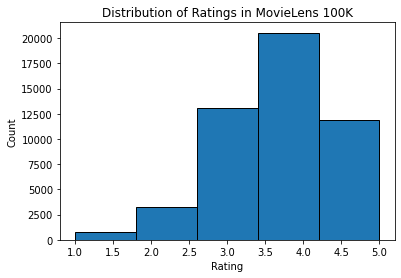

In [43]:
# === Distribution of ratings of rated books === #
# i.e. without the books with a rating of 0
plt.hist(inters_rated['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

Here's what a subset of it looks like as a crosstabulation, which makes it into a dense matrix.

In [47]:
# === Create crosstab of users-books === #
g=inters_rated.groupby("user_id")["rating"].count()
topUsers=g.sort_values(ascending=False)[:15]

g=inters_rated.groupby("book_id")["rating"].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = inters_rated.join(topUsers, rsuffix="_r", how="inner", on="user_id")
top_r = top_r.join(topMovies, rsuffix="_r", how="inner", on="book_id")

pd.crosstab(top_r["user_id"], top_r["book_id"], top_r["rating"], aggfunc=np.sum)

book_id,1085,11,142,154,166,180,181,24,25,376,49,53,69,71,84
user_id,,,,,,,,,,,,,,,
1002,NaN,NaN,4.0,4.0,4.0,4.0,5.0,4.0,1.0,NaN,5.0,1.0,NaN,4.0,NaN
1253,NaN,5.0,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
1400,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN
266,4.0,NaN,4.0,NaN,NaN,5.0,5.0,NaN,3.0,NaN,5.0,4.0,NaN,4.0,4.0
314,NaN,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
368,3.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,4.0,4.0,4.0,4.0,NaN,3.0,NaN
482,5.0,5.0,5.0,NaN,NaN,5.0,5.0,3.0,NaN,NaN,5.0,NaN,4.0,5.0,5.0
518,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


---
---

## Modeling

For this model, I'll be using the FastAI collaborative filtering algorithm(s).

Resources:

* [fastai.collab](https://docs.fast.ai/collab.html)
* [movielens recommender example](https://github.com/microsoft/recommenders/blob/master/notebooks/00_quick_start/fastai_movielens.ipynb)

In [50]:
# === First, train on rated books only === #
rating_range = [1, 5]

# Create databunch
data = CollabDataBunch.from_df(
    inters_rated,
    user_name="user_id",
    item_name="book_id",
    rating_name="rating",
    valid_pct=0.2,
    seed=92
)

# === Instantiate learner === #
learn = collab_learner(data, n_factors=50, y_range=rating_range)
learn.model

In [51]:
data.show_batch()

user_id,book_id,target
82,51,4.0
1761,8945,2.0
779,13588,3.0
1627,22778,5.0
1720,3098,4.0


In [53]:
# === Train! === #
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.123155,1.084469,00:10
1,0.634403,0.753151,00:12
2,0.298588,0.739403,00:12
3,0.128401,0.741949,00:11
4,0.073346,0.742687,00:10


In [59]:
# === Export trained model === #
learn.export("/content/drive/My Drive/workshop/buildbox/likewise/assets/models/01_likewise.pkl")

---

## Generate Recommendations

In [60]:
# === Import the model from file === #
learner = load_learner(
    path="/content/drive/My Drive/workshop/buildbox/likewise/assets/models/",
    file="01_likewise.pkl",
)

In [65]:
# === Get all users and items that the model knows === #
total_users, total_items = learner.data.train_ds.x.classes.values()
total_items = total_items[1:]
total_users = total_users[1:]

print(total_users.shape, total_items.shape)

(1613,) (15925,)


In [ ]:
# Get all users from the test set and remove any users
# that were know in the training set

test_users = test_df[USER].unique()
test_users = np.intersect1d(test_users, total_users)

In [67]:
from itertools import product

users_items = product(np.array(total_users), np.array(total_items))
users_items = pd.DataFrame(users_items, columns=["user_id", "book_id"])

In [68]:
users_items

,user_id,book_id
0,1,1
1,1,10
2,1,100
3,1,1000
4,1,10001
...,...,...
25687020,999,9990
25687021,999,9992
25687022,999,9993
25687023,999,9996


My search for how to generate recommendations led me to looking at the [`score` function](https://github.com/microsoft/recommenders/blob/master/reco_utils/recommender/fastai/fastai_utils.py) in the reco_utils module, which is used in one of the notebooks I'm referencing [here](https://github.com/microsoft/recommenders/blob/master/notebooks/00_quick_start/fastai_movielens.ipynb).

I copied the `score` function into the cell below to try and use some of it to write my own recommendation function.

In [ ]:
def score(
    learner,
    test_df,
    user_col=cc.DEFAULT_USER_COL,
    item_col=cc.DEFAULT_ITEM_COL,
    prediction_col=cc.DEFAULT_PREDICTION_COL,
    top_k=None,
):
    """Score all users+items provided and reduce to top_k items per user if top_k>0
    
    Args:
        learner (obj): Model.
        test_df (pd.DataFrame): Test dataframe.
        user_col (str): User column name.
        item_col (str): Item column name.
        prediction_col (str): Prediction column name.
        top_k (int): Number of top items to recommend.
    Returns:
        pd.DataFrame: Result of recommendation 
    """
    # replace values not known to the model with NaN
    total_users, total_items = learner.data.train_ds.x.classes.values()
    test_df.loc[~test_df[user_col].isin(total_users), user_col] = np.nan
    test_df.loc[~test_df[item_col].isin(total_items), item_col] = np.nan

    # map ids to embedding ids
    u = learner.get_idx(test_df[user_col], is_item=False)
    m = learner.get_idx(test_df[item_col], is_item=True)

    # score the pytorch model
    pred = learner.model.forward(u, m)
    scores = pd.DataFrame(
        {user_col: test_df[user_col], item_col: test_df[item_col], prediction_col: pred}
    )
    scores = scores.sort_values([user_col, prediction_col], ascending=[True, False])
    if top_k is not None:
        top_scores = scores.groupby(user_col).head(top_k).reset_index(drop=True)
    else:
        top_scores = scores
    return top_scores